### Laboratory 1 — Clustering comparison
#### Author: Corețchi Mihai

We apply and compare **4 clustering families** on the same dataset (`data/data.csv`):
- K-Means (partitional)
- Agglomerative (hierarchical) + dendrogram
- DBSCAN (density-based)
- Gaussian Mixture / EM (probabilistic)

For each method: short idea, cluster plot, **silhouette score**, and a brief comment on compactness/separation.

In [69]:
!pip install -q pandas numpy scikit-learn matplotlib seaborn scipy

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["figure.dpi"] = 120

RANDOM_STATE = 42

## Load data + prepare features (numeric + categorical)

We use:
- **numeric columns** (impute median + standardize)
- a few **categorical columns** (impute most-frequent + one-hot)

To keep it reasonable, we **exclude ID-like columns** (TransactionID, AccountID, DeviceID, IP, MerchantID) and raw date strings.

In [71]:
data_path = Path("data/data.csv")
df = pd.read_csv(data_path)

# --- Feature selection (simple + safe) ---
# Use ALL numeric columns, plus a small set of meaningful categoricals.
# Exclude IDs / high-cardinality identifiers and raw date strings.
exclude_cols = {
    "TransactionID",
    "AccountID",
    "DeviceID",
    "IP Address",
    "MerchantID",
    "TransactionDate",
    "PreviousTransactionDate",
}

numeric_cols = [c for c in df.select_dtypes(include="number").columns if c not in exclude_cols]

# Keep a small, interpretable set of categoricals
candidate_categoricals = ["TransactionType", "Location", "Channel", "CustomerOccupation"]
categorical_cols = [c for c in candidate_categoricals if c in df.columns and c not in exclude_cols]

print(f"Numeric cols ({len(numeric_cols)}): {numeric_cols}")
print(f"Categorical cols ({len(categorical_cols)}): {categorical_cols}")

# --- Preprocessing pipelines ---
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, numeric_cols),
    ("cat", categorical_pipe, categorical_cols),
], remainder="drop")

X = preprocess.fit_transform(df)

# Many clusterers need dense arrays; this dataset is small enough to densify.
if hasattr(X, "toarray"):
    X = X.toarray()

print(f"Final X shape: {X.shape}")

# 2D embedding for plotting (used for ALL methods)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=df.index)
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_.round(3)}")

Numeric cols (5): ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
Categorical cols (4): ['TransactionType', 'Location', 'Channel', 'CustomerOccupation']
Final X shape: (2512, 57)
PCA explained variance ratio: [0.195 0.134]


## Helpers: plotting + silhouette

- **Silhouette score**: higher is better; it reflects **compact clusters** (low intra-cluster distances) and **well-separated clusters** (high inter-cluster distances).
- Some methods can output **noise** (DBSCAN) or **1 cluster**; silhouette is not defined in those cases.

In [72]:
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

def safe_silhouette(X_full, labels):
    """Return silhouette score or None if not defined."""
    labels = np.asarray(labels)
    # ignore NaN labels, if any
    mask = ~pd.isna(labels)
    labels = labels[mask]
    X_use = X_full[mask]

    unique = np.unique(labels)
    if len(unique) < 2:
        return None
    if len(labels) < 3:
        return None

    try:
        return float(silhouette_score(X_use, labels))
    except Exception:
        return None


def plot_clusters_2d(pca_df, labels, title, noise_label=-1):
    plot_df = pca_df.copy()
    plot_df["cluster"] = labels

    plt.figure(figsize=(8, 5))

    # Noise points first (gray)
    if noise_label is not None and (plot_df["cluster"] == noise_label).any():
        noise = plot_df[plot_df["cluster"] == noise_label]
        sns.scatterplot(
            data=noise, x="PC1", y="PC2",
            color="gray", alpha=0.35, s=25, label="noise"
        )
        rest = plot_df[plot_df["cluster"] != noise_label]
    else:
        rest = plot_df

    if len(rest) > 0:
        sns.scatterplot(
            data=rest, x="PC1", y="PC2",
            hue="cluster", palette="tab10",
            alpha=0.8, s=35
        )

    plt.title(title)
    plt.legend(title="cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def plot_silhouette_vs_k(X_full, title, k_min=2, k_max=10, clusterer_factory=None):
    ks = list(range(k_min, k_max + 1))
    scores = []
    for k in ks:
        clusterer = clusterer_factory(k)
        labels = clusterer.fit_predict(X_full)
        scores.append(safe_silhouette(X_full, labels))

    plt.figure(figsize=(7.5, 4))
    sns.lineplot(x=ks, y=scores, marker="o")
    plt.title(title)
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.xticks(ks)
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.show()


def k_distance_values(X_full, k):
    """Return sorted k-distance values for DBSCAN eps selection."""
    nbrs = NearestNeighbors(n_neighbors=k)
    nbrs.fit(X_full)
    distances, _ = nbrs.kneighbors(X_full)
    k_dist = np.sort(distances[:, -1])
    return k_dist

## 1) Partitional clustering — K-Means

**Idea**: iteratively assign points to the nearest centroid, then recompute centroids until convergence.

**Main steps**:
- initialize centroids
- assign points to nearest centroid
- update centroids
- repeat until stable

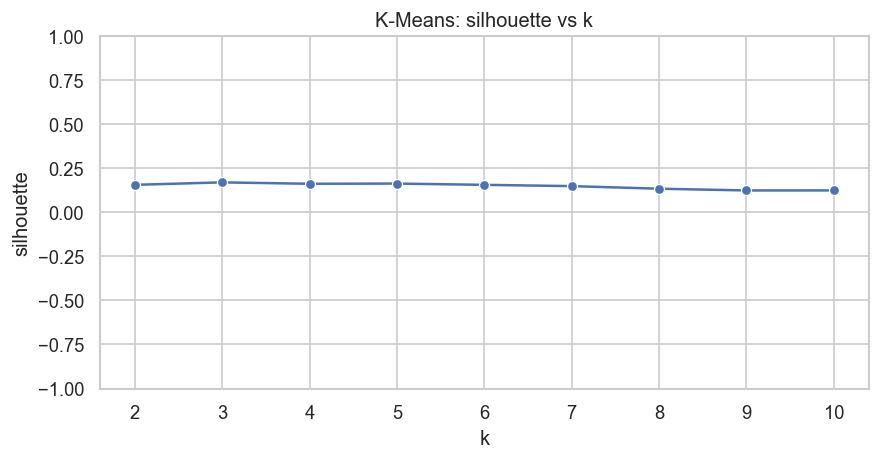

In [73]:
# Choose k visually: silhouette vs k (higher is better)
plot_silhouette_vs_k(
    X,
    title="K-Means: silhouette vs k",
    k_min=2,
    k_max=10,
    clusterer_factory=lambda kk: KMeans(n_clusters=kk, random_state=RANDOM_STATE, n_init="auto"),
)

K-Means: k=2, silhouette=0.156


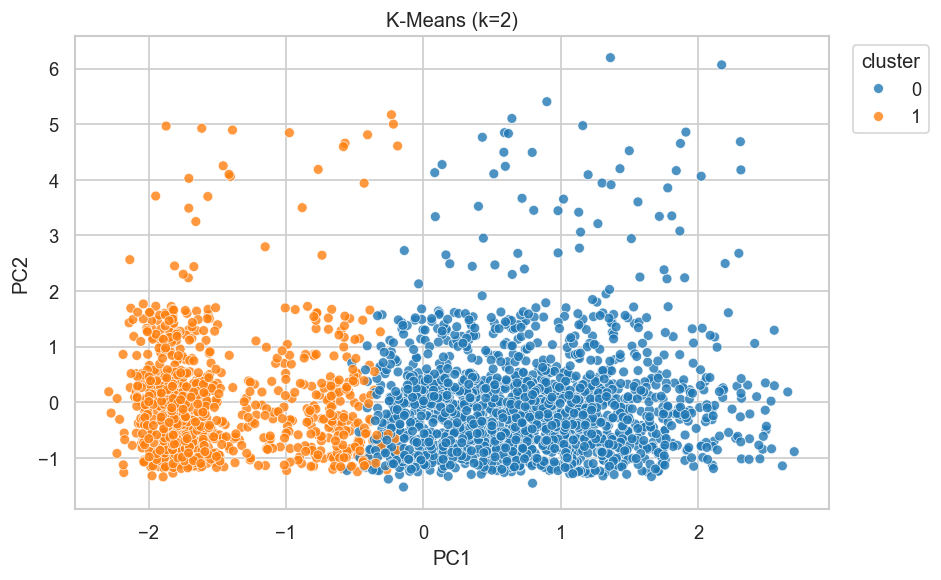

In [74]:
from sklearn.cluster import KMeans

km_k = 2

kmeans = KMeans(n_clusters=km_k, random_state=RANDOM_STATE, n_init="auto")
kmeans_labels = kmeans.fit_predict(X)

kmeans_sil = safe_silhouette(X, kmeans_labels)
print(f"K-Means: k={km_k}, silhouette={kmeans_sil:.3f}" if kmeans_sil is not None else f"K-Means: k={km_k}, silhouette=undefined")

plot_clusters_2d(pca_df, kmeans_labels, title=f"K-Means (k={km_k})")

## 2) Hierarchical clustering — Agglomerative + dendrogram

**Idea**: start with each point as its own cluster, then repeatedly **merge** the closest clusters (bottom-up).

**Main steps**:
- compute distances between clusters
- merge the closest pair
- repeat until k clusters (or one cluster)

We also draw a **dendrogram** (tree of merges).

Agglomerative: k=2, silhouette=0.135


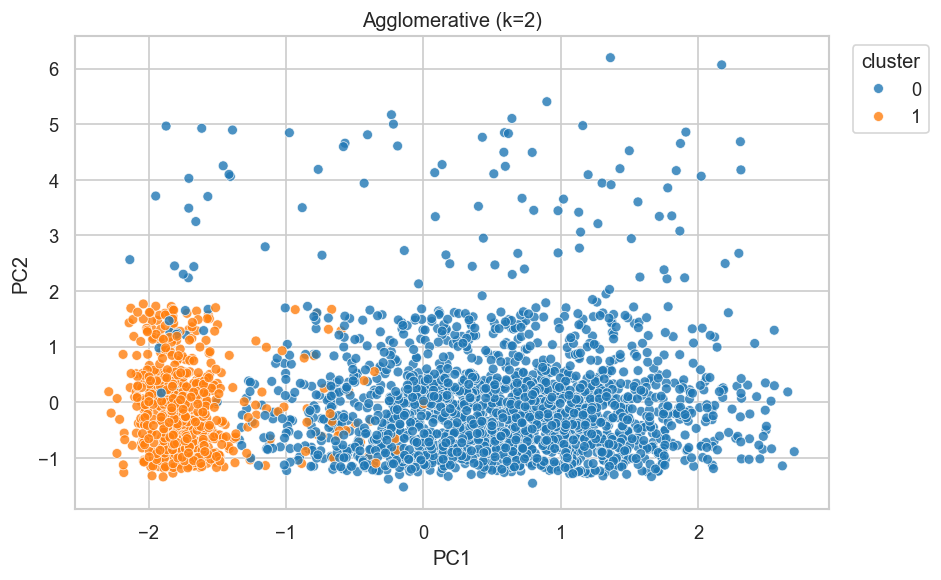

In [75]:
from sklearn.cluster import AgglomerativeClustering
hc_k = 2
agg = AgglomerativeClustering(n_clusters=hc_k, linkage="ward")
agg_labels = agg.fit_predict(X)

agg_sil = safe_silhouette(X, agg_labels)
print(f"Agglomerative: k={hc_k}, silhouette={agg_sil:.3f}" if agg_sil is not None else "Agglomerative: silhouette=undefined")
title = f"Agglomerative (k={hc_k})"
plot_clusters_2d(pca_df, agg_labels, title)

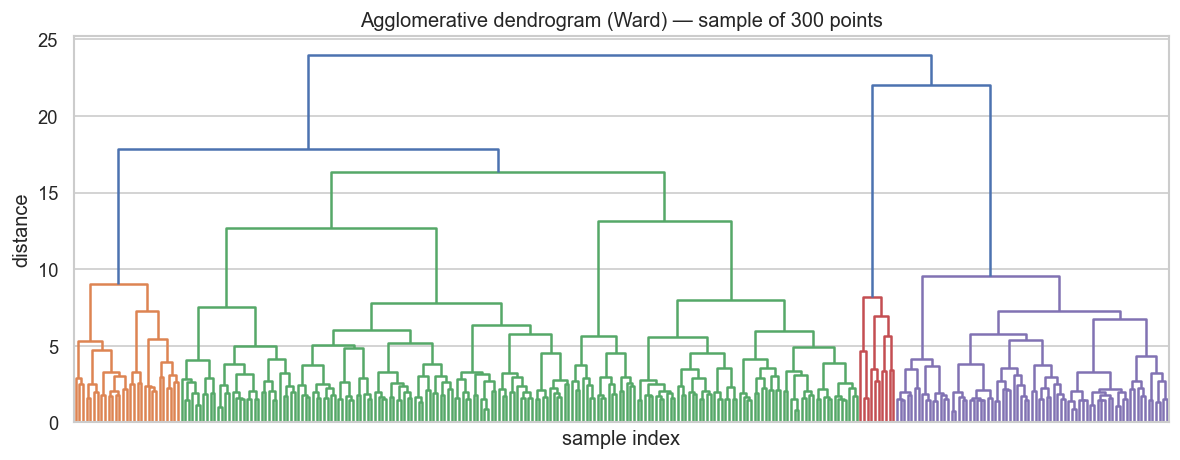

In [76]:
# Dendrogram (computed on a random sample for readability)
from scipy.cluster.hierarchy import linkage, dendrogram

sample_n = min(300, X.shape[0])
rs = np.random.RandomState(RANDOM_STATE)
sample_idx = rs.choice(np.arange(X.shape[0]), size=sample_n, replace=False)

Z = linkage(X[sample_idx], method="ward")

plt.figure(figsize=(10, 4))
dendrogram(Z, no_labels=True, color_threshold=None)
plt.title(f"Agglomerative dendrogram (Ward) — sample of {sample_n} points")
plt.xlabel("sample index")
plt.ylabel("distance")
plt.tight_layout()
plt.show()

## 3) Density-based clustering — DBSCAN

**Idea**: dense regions become clusters; sparse regions become **noise**.

**Main steps**:
- define neighborhood radius `eps`
- points with enough neighbors are *core* points
- clusters grow from core points by density reachability

We use a **k-distance plot** (k = `min_samples`) to help choose `eps`.

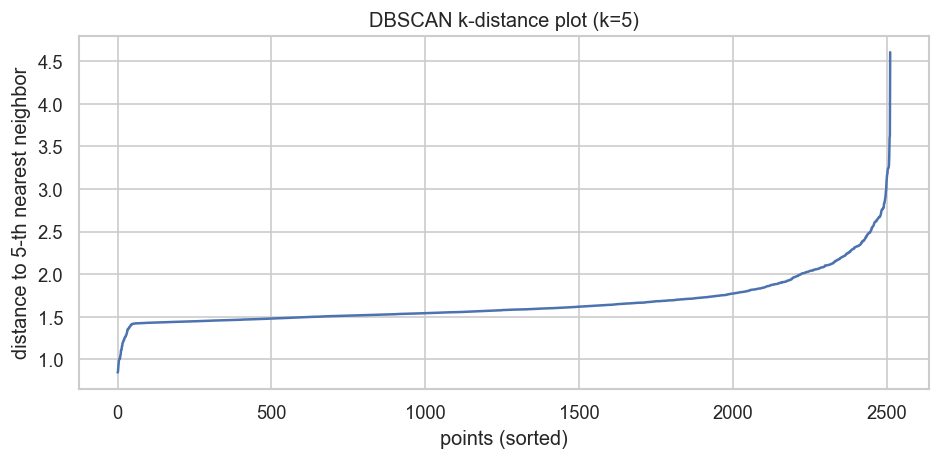

Baseline eps (95th percentile of k-distances): 2.285
DBSCAN: clusters=4, noise=3.0%


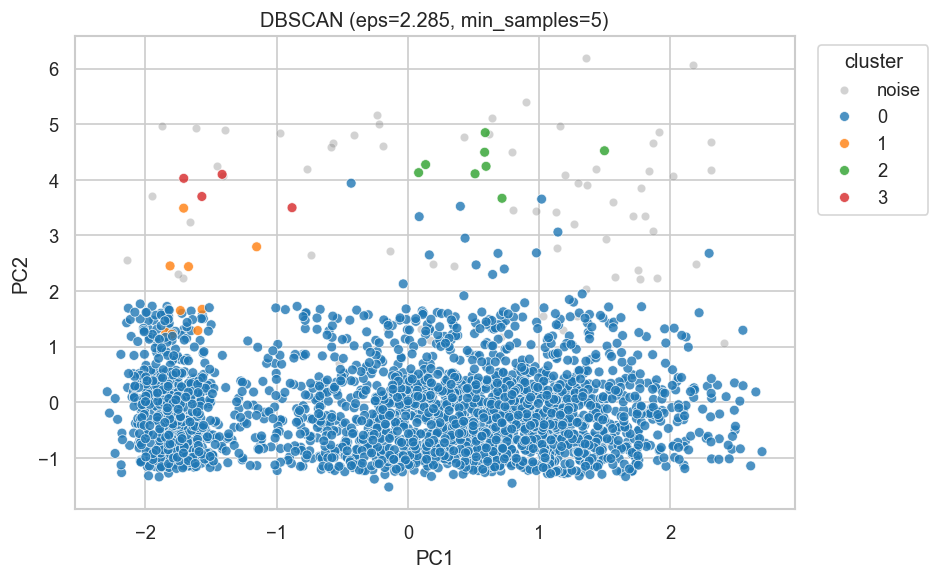

DBSCAN silhouette (excluding noise) = 0.301


In [77]:
from sklearn.cluster import DBSCAN

min_samples = 5
k_dist = k_distance_values(X, k=min_samples)

plt.figure(figsize=(8, 4))
sns.lineplot(x=np.arange(len(k_dist)), y=k_dist)
plt.title(f"DBSCAN k-distance plot (k={min_samples})")
plt.xlabel("points (sorted)")
plt.ylabel(f"distance to {min_samples}-th nearest neighbor")
plt.tight_layout()
plt.show()

# Simple baseline eps choice (you can override after looking at the plot)
eps = float(np.percentile(k_dist, 95))
print(f"Baseline eps (95th percentile of k-distances): {eps:.3f}")

db = DBSCAN(eps=eps, min_samples=min_samples)
db_labels = db.fit_predict(X)

n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
noise_pct = 100.0 * np.mean(db_labels == -1)
print(f"DBSCAN: clusters={n_clusters}, noise={noise_pct:.1f}%")

plot_clusters_2d(pca_df, db_labels, title=f"DBSCAN (eps={eps:.3f}, min_samples={min_samples})", noise_label=-1)

# Silhouette is undefined with 1 cluster; with noise, we compute it on non-noise points only
non_noise = db_labels != -1
if np.sum(non_noise) > 2 and len(np.unique(db_labels[non_noise])) >= 2:
    db_sil = safe_silhouette(X[non_noise], db_labels[non_noise])
else:
    db_sil = None

print(f"DBSCAN silhouette (excluding noise) = {db_sil:.3f}" if db_sil is not None else "DBSCAN silhouette: undefined")

## 4) Probabilistic clustering — Gaussian Mixture Model (EM)

**Idea**: data is generated by a mixture of Gaussians; EM learns parameters to maximize likelihood.

**Main steps**:
- E-step: compute membership probabilities for each component
- M-step: update Gaussian parameters

We plot **hard labels** (argmax component), but the model is inherently **soft**.

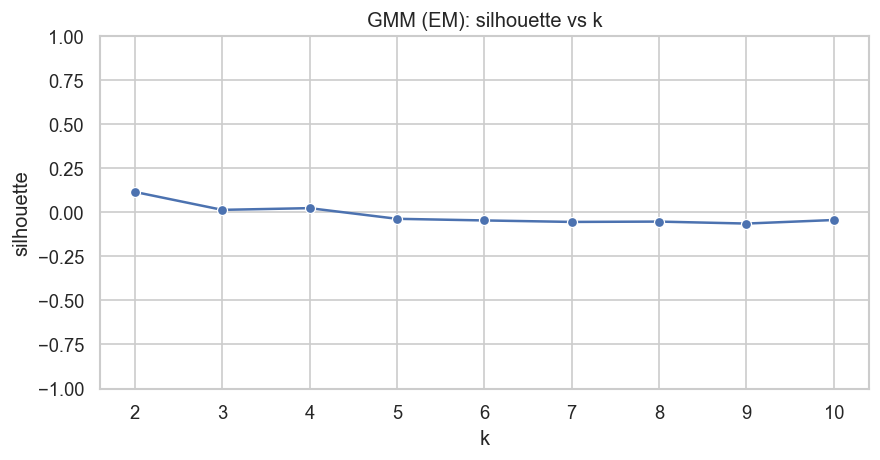

In [78]:
# Choose k visually: silhouette vs k (probabilistic model)
plot_silhouette_vs_k(
    X,
    title="GMM (EM): silhouette vs k",
    k_min=2,
    k_max=10,
    clusterer_factory=lambda kk: GaussianMixture(n_components=kk, random_state=RANDOM_STATE),
)

GMM: k=2, silhouette=0.116


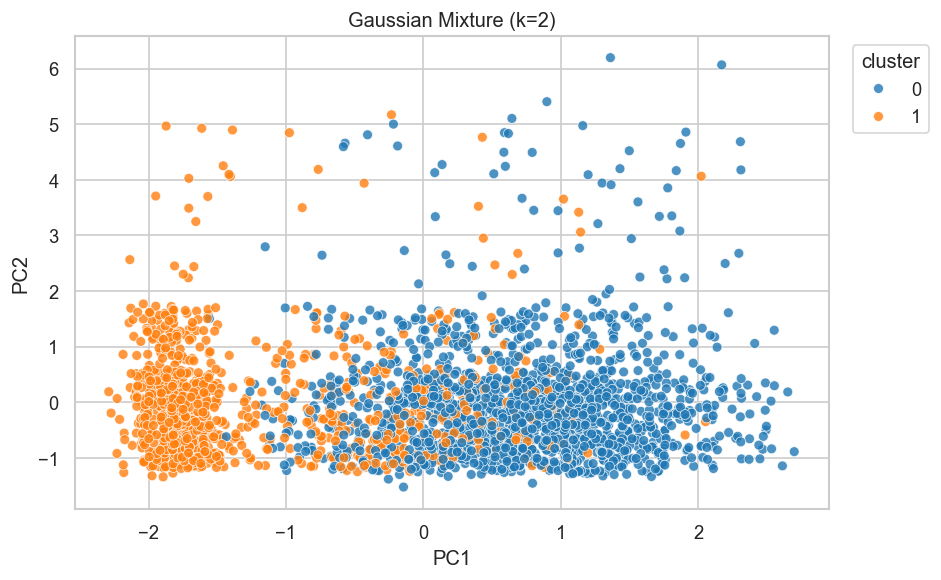

Mean max-component probability: 1.000


In [79]:
from sklearn.mixture import GaussianMixture

gmm_k = 2

gmm = GaussianMixture(n_components=gmm_k, random_state=RANDOM_STATE)
gmm_labels = gmm.fit_predict(X)

gmm_sil = safe_silhouette(X, gmm_labels)
print(f"GMM: k={gmm_k}, silhouette={gmm_sil:.3f}" if gmm_sil is not None else f"GMM: k={gmm_k}, silhouette=undefined")

plot_clusters_2d(pca_df, gmm_labels, title=f"Gaussian Mixture (k={gmm_k})")

# Optional: see how confident the model is (max posterior per point)
max_prob = gmm.predict_proba(X).max(axis=1)
print(f"Mean max-component probability: {max_prob.mean():.3f}")

## Comparative summary

We compare the methods using silhouette score (when defined) and practical behavior on this data.

In [80]:
results = []

results.append({
    "method": "K-Means",
    "params": f"k={km_k}",
    "n_clusters": len(np.unique(kmeans_labels)),
    "noise_%": 0.0,
    "silhouette": kmeans_sil,
})

results.append({
    "method": "Agglomerative",
    "params": f"ward, k={hc_k}",
    "n_clusters": len(np.unique(agg_labels)),
    "noise_%": 0.0,
    "silhouette": agg_sil,
})

results.append({
    "method": "DBSCAN",
    "params": f"eps={eps:.3f}, min_samples={min_samples}",
    "n_clusters": len(set(db_labels)) - (1 if -1 in db_labels else 0),
    "noise_%": float(100.0 * np.mean(db_labels == -1)),
    "silhouette": db_sil,
})

results.append({
    "method": "GMM",
    "params": f"k={gmm_k}",
    "n_clusters": len(np.unique(gmm_labels)),
    "noise_%": 0.0,
    "silhouette": gmm_sil,
})

summary_df = pd.DataFrame(results)
summary_df

,method,params,n_clusters,noise_%,silhouette
0,K-Means,k=2,2,0.000000,0.156225
1,Agglomerative,"ward, k=2",2,0.000000,0.135437
2,DBSCAN,"eps=2.285, min_samples=5",4,3.025478,0.301059
3,GMM,k=2,2,0.000000,0.115932


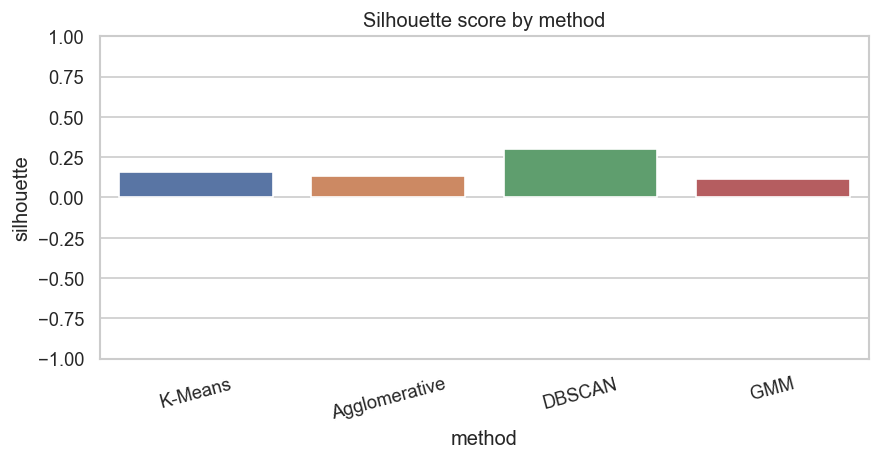

In [81]:
# Visual comparison of silhouette scores (drop undefined)
plot_df = summary_df.dropna(subset=["silhouette"]).copy()

plt.figure(figsize=(7.5, 4))
sns.barplot(data=plot_df, x="method", y="silhouette", hue="method", legend=False)
plt.title("Silhouette score by method")
plt.ylim(-1, 1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### Short conclusions (strengths / weaknesses)

- **K-Means**: fast and simple; best when clusters are roughly spherical and similar size; needs `k`.
- **Agglomerative (Ward)**: dendrogram helps interpretation; can be slower on large datasets; needs a final cut at `k`.
- **DBSCAN**: finds arbitrary shapes and detects **noise/outliers**; no need for `k`; sensitive to `eps` and struggles if densities vary.
- **GMM (EM)**: like “soft K-Means”; can model elliptical clusters; provides probabilities; can be sensitive to initialization/model mismatch.

**For this dataset (numeric + categorical transaction features)**:
- Standardization + one-hot encoding matters a lot (we did it).
- To choose a better `k`, use the **silhouette-vs-k** plots (K-Means and GMM). Higher silhouette usually means better compactness + separation.
- To tune DBSCAN, use the **k-distance** plot and adjust `eps` until you get a reasonable number of clusters and not too much noise.